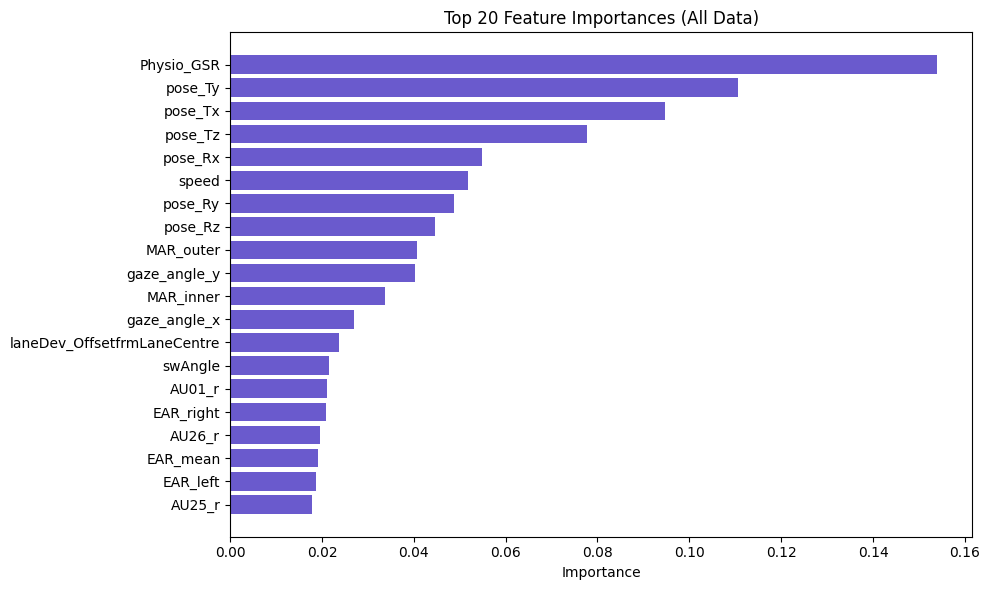


🔍 Ranked Feature Importance:
                    Feature  Importance
                 Physio_GSR    0.153935
                    pose_Ty    0.110683
                    pose_Tx    0.094723
                    pose_Tz    0.077730
                    pose_Rx    0.054949
                      speed    0.051719
                    pose_Ry    0.048700
                    pose_Rz    0.044725
                  MAR_outer    0.040718
               gaze_angle_y    0.040348
                  MAR_inner    0.033834
               gaze_angle_x    0.027013
laneDev_OffsetfrmLaneCentre    0.023659
                    swAngle    0.021504
                     AU01_r    0.021005
                  EAR_right    0.020834
                     AU26_r    0.019655
                   EAR_mean    0.019055
                   EAR_left    0.018763
                     AU25_r    0.017933
                     AU15_r    0.014136
                     AU45_r    0.012037
                     AU01_c    0.007537
          

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# === Settings ===
data_dir = 'Classification_Combined_Data/Combined_S1S2_clean'
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}

non_features = ['ID', 'record_time', 'UNIX', 'Label_unify', 'Label_num']
signal_features = [
    'EAR_left', 'EAR_right', 'EAR_mean',
    'MAR_inner', 'MAR_outer',
    'AU01_c', 'AU01_r', 'AU15_c', 'AU15_r', 'AU25_c', 'AU25_r',
    'AU26_c', 'AU26_r', 'AU45_c', 'AU45_r',
    'pose_Tx', 'pose_Ty', 'pose_Tz',
    'pose_Rx', 'pose_Ry', 'pose_Rz',
    'gaze_angle_x', 'gaze_angle_y',
    'Physio_ECG', 'Physio_GSR',
    'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed'
]

# === Combine all files ===
df_list = []
for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv(os.path.join(data_dir, file))
    df = df.dropna(subset=['Label_unify'])
    df['Label_unify'] = df['Label_unify'].map(label_map)
    df = df[df['Label_unify'].notna()]
    df_list.append(df)

full_df = pd.concat(df_list, ignore_index=True)

# === Features and Labels ===
X = full_df[signal_features].fillna(0)
y = full_df['Label_unify']

# === Encode Labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Train Random Forest ===
rf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
rf.fit(X, y_enc)

# === Feature Importance ===
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': signal_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# === Plot Top 20 ===
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1], color='slateblue')
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (All Data)")
plt.tight_layout()
plt.show()

# === Show Ranked Features ===
print("\n🔍 Ranked Feature Importance:")
print(importance_df.head(30).to_string(index=False))

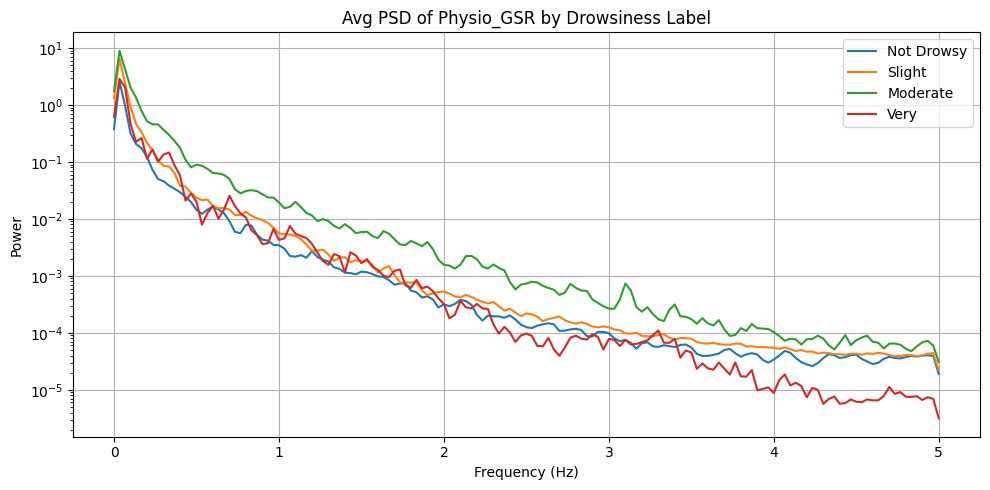

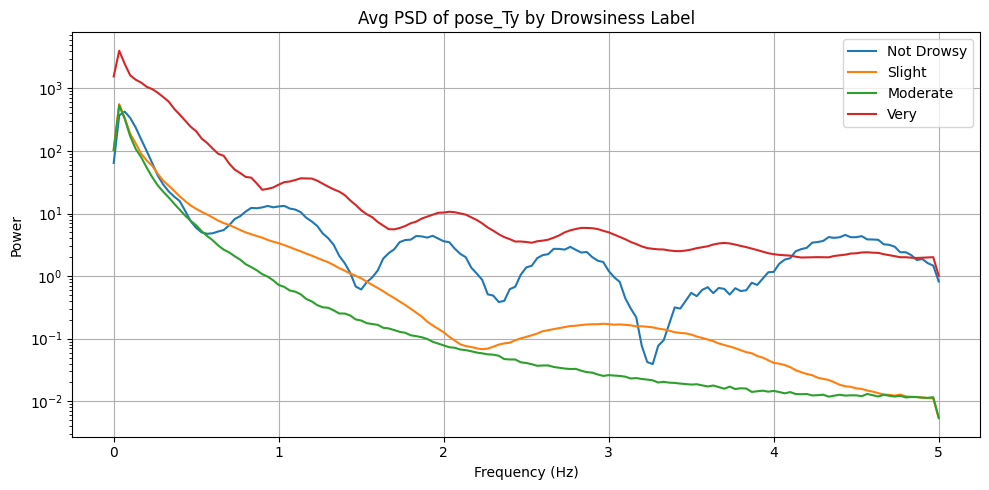

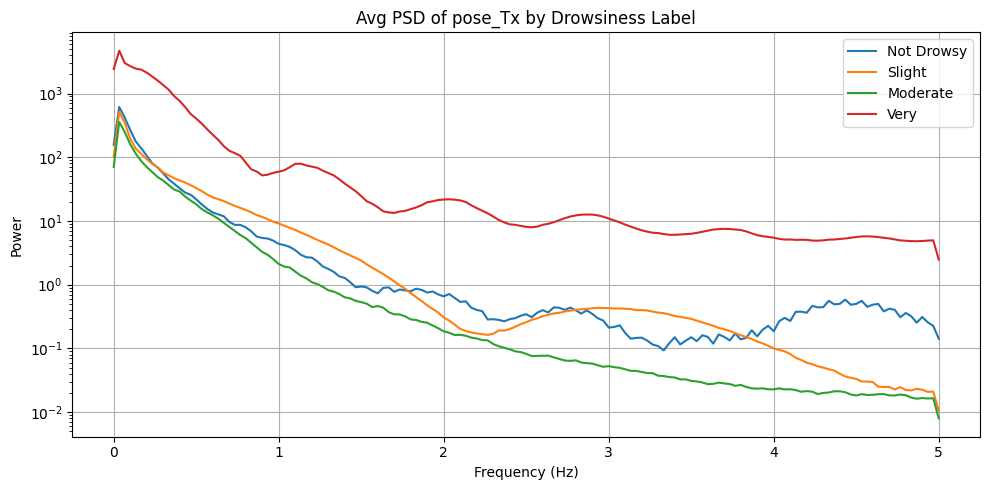

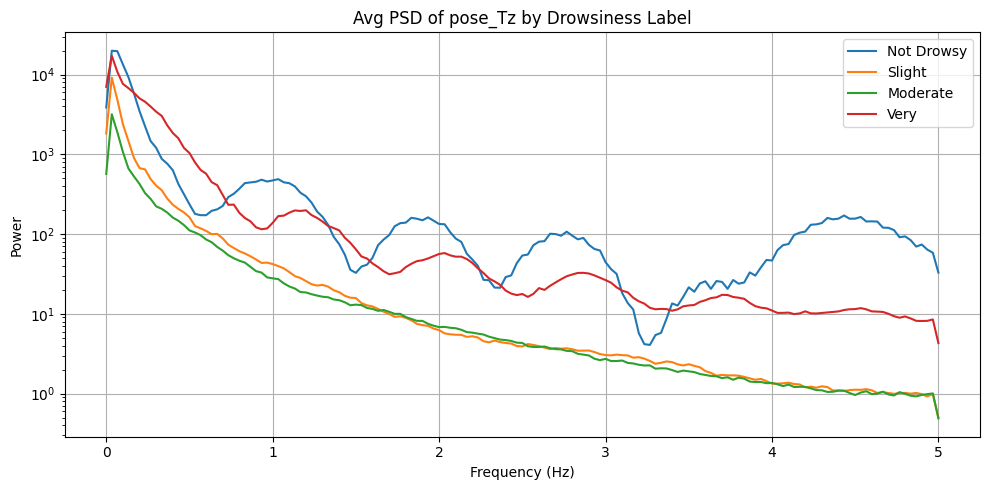

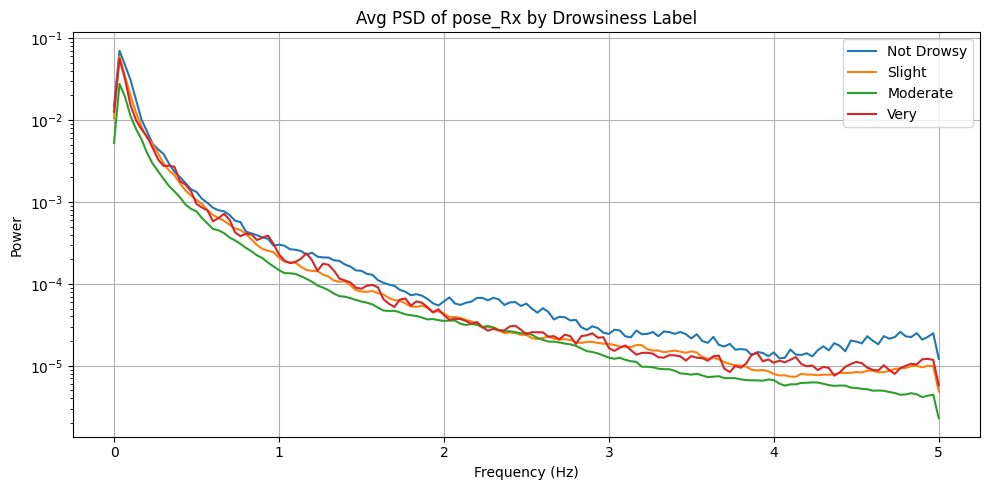

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

data_dir = 'Classification_Combined_Data/Combined_S1S2_clean'
target_signals = ['Physio_GSR', 'pose_Ty', 'pose_Tx', 'pose_Tz', 'pose_Rx']
fs = 10  # Hz
window_sec = 30
window_samples = fs * window_sec

# Store PSDs per signal per label
psd_store = {signal: {} for signal in target_signals}

for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue

    df = pd.read_csv(os.path.join(data_dir, file))
    df = df.dropna(subset=target_signals + ['Label_unify'])

    for label in df['Label_unify'].dropna().unique():
        df_label = df[df['Label_unify'] == label]

        for signal in target_signals:
            signal_data = df_label[signal].values

            for i in range(0, len(signal_data) - window_samples + 1, window_samples):
                segment = signal_data[i:i+window_samples]
                if len(segment) == window_samples:
                    freqs, psd = welch(segment, fs=fs, nperseg=window_samples)
                    psd_store[signal].setdefault(label, []).append(psd)

# === Plot aggregated PSDs ===
for signal in target_signals:
    plt.figure(figsize=(10, 5))
    for label, psd_list in psd_store[signal].items():
        avg_psd = np.mean(psd_list, axis=0)
        plt.semilogy(freqs, avg_psd, label=label)
    plt.title(f"Avg PSD of {signal} by Drowsiness Label")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()